In [27]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
!python train.py

Using cuda
Epoch [1/1], step [100/235], d_loss: 0.0197, g_loss: 7.7114, D(x): 0.99, Discriminator - D(G(x)): 0.01, Generator - D(G(x)): 0.00
Epoch [1/1], step [200/235], d_loss: 0.0039, g_loss: 7.3400, D(x): 1.00, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00


Using cuda
Epoch [1/100], step [100/235], d_loss: 0.0187, g_loss: 7.6703, D(x): 0.99, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [1/100], step [200/235], d_loss: 0.0067, g_loss: 8.5591, D(x): 1.00, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [2/100], step [100/235], d_loss: 0.0029, g_loss: 8.6138, D(x): 1.00, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [2/100], step [200/235], d_loss: 0.0008, g_loss: 9.4916, D(x): 1.00, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [3/100], step [100/235], d_loss: 0.0027, g_loss: 8.5710, D(x): 1.00, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [3/100], step [200/235], d_loss: 0.0015, g_loss: 10.3930, D(x): 1.00, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [4/100], step [100/235], d_loss: 0.0079, g_loss: 7.0240, D(x): 1.00, Discriminator - D(G(x)): 0.01, Generator - D(G(x)): 0.00
Epoch [4/100], step [200/235], d_loss: 0.0068, g_loss: 7.3355, D

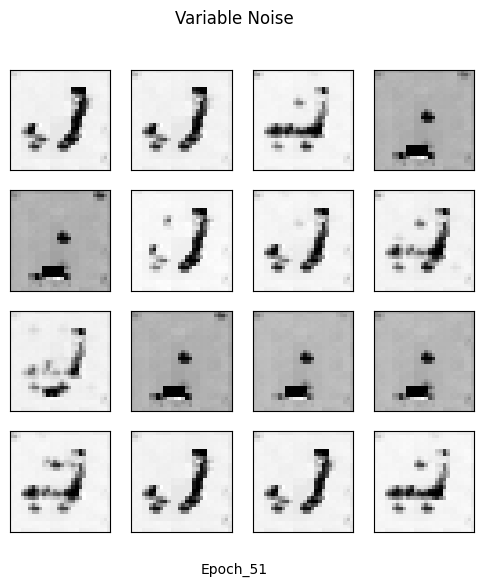

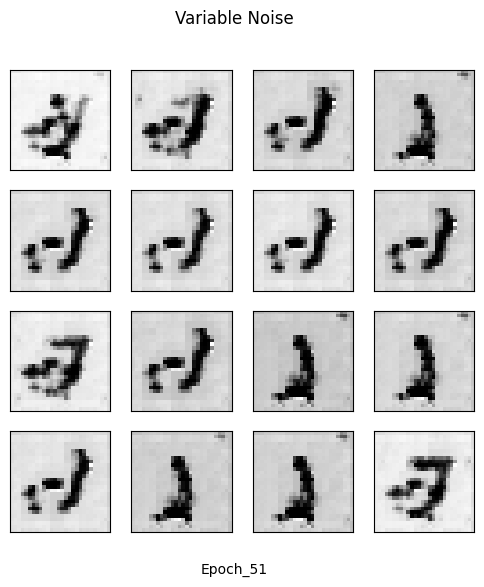

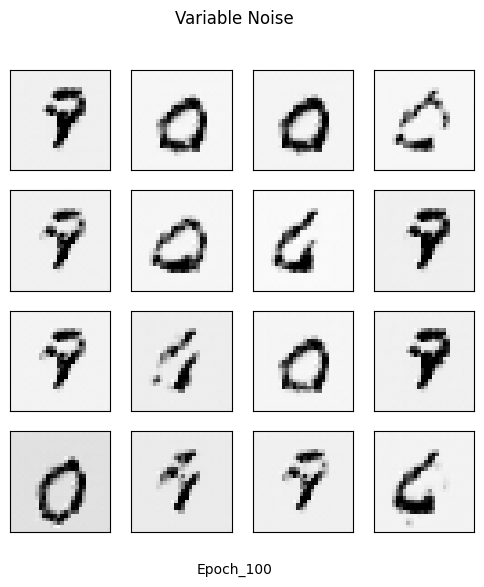

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from torchvision.utils import save_image
from torchsummary import summary

import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# The below 2 lines should be in a separate Jupyter NB file
# for train.py to run in Google Colab
# Keeping this line inside train.py will give error while
# running in Colab with just `python train.py`
# from google.colab import drive
# drive.mount("/content/drive")

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

from utils import *
from utils import plot_images
from dcgan import *


def train(
    num_epochs,
    discriminator_net,
    generator_net,
    optimizerD,
    optimizerG,
    train_loader,
    fake_label,
    real_label,
    criterion,
    output_path,
    num_test_samples,
    device,
    noise_vector,
):
    num_batches = len(train_loader)

    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(train_loader):
            batch_size_real_imgs = real_images.shape[0]

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            """ The standard process to train a DCGAN network is to first train
            the discriminator on the batch of samples.
            """
            discriminator_net.zero_grad()

            real_images = real_images.to(device)

            # First training on real image, hence fill it with 1
            # Create Labels
            label = torch.full((batch_size_real_imgs,), real_label, device=device)

            """ The discriminator is used to classify real images (drawn from the training set)
            and fake images (produced by the generator).
            So, next, train the discriminator network on real images and real labels:
            """
            output = discriminator_net(real_images)

            loss_disc_real = criterion(output, label)

            loss_disc_real.backward()

            D_x = output.mean().item()

            # Creating noise variables for the input to whole adversarial network
            noise = torch.randn(batch_size_real_imgs, noise_vector, 1, 1, device=device)

            # Generate a batch of fake images using the generator network
            fake_images = generator_net(noise)

            # As now training on fake image, fill label with 0's
            label.fill_(fake_label)

            # Now train Discriminator on fake images
            output = discriminator_net(fake_images.detach())

            loss_disc_fake = criterion(output, label)
            loss_disc_fake.backward()

            D_G_z1 = output.mean().item()

            # Total Discriminator Loss
            loss_disc_total = loss_disc_real + loss_disc_fake

            optimizerD.step()

            ############################
            # (2) Update Generator network: maximize log(D(G(z)))
            ###########################

            """ When we train the generator network we have to
            freeze the discriminator network, as we have already trained it. """

            generator_net.zero_grad()

            # Now, set Image Label vector values equal to 1
            # To fool the Discriminator Network
            label.fill_(real_label)

            # After filling all labels with 1 (representing real labels), run discriminator network with fake images to fool it
            # To classify real images (drawn from the training set) and fakes images (produced by the generator).
            output = discriminator_net(fake_images)

            # And now after I tried to fool discriminator, check how much it was fooled.
            # so to the extent above output does not match with "labels" variable (which were all filed up with 1)
            # That will be the failure of Generator Network i.e. Generator Loss
            loss_generator = criterion(output, label)

            loss_generator.backward()

            D_G_z2 = output.mean().item()

            optimizerG.step()

            if (i + 1) % 100 == 0:
                print(
                    "Epoch [{}/{}], step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, Discriminator - D(G(x)): {:.2f}, Generator - D(G(x)): {:.2f}".format(
                        epoch + 1,
                        num_epochs,
                        i + 1,
                        num_batches,
                        loss_disc_total.item(),
                        loss_generator.item(),
                        D_x,
                        D_G_z1,
                        D_G_z2,
                    )
                )
                if epoch==int(num_epochs/2):
                  plot_images(
                          epoch,
                          output_path,
                          num_test_samples,
                          generator_net,
                          device,)

    generator_net.eval()
    if epoch % 2==0:
      plot_images(
      epoch,
      output_path,
      num_test_samples,
      generator_net,
      device,)
    plot_images(
    epoch,
    output_path,
    num_test_samples,
    generator_net,
    device,)
    generator_net.train()


##########################################
# Initialize all the necessary variables
#########################################

batch_size = 256

output_path = "/content/sample_data/"

# Gather MNIST Dataset
train_loader = get_data_loader(batch_size)

# Create the Discriminator and Generator network
discriminator_net = Discriminator(num_ch=1, num_disc_filter=32).to(device)

generator_net = Generator(num_ch=1, noise_vector=100, num_gen_filter=32).to(device)

# loss function
criterion = nn.BCELoss()

# optimizers
optimizerD = optim.Adam(discriminator_net.parameters(), lr=0.001)
optimizerG = optim.Adam(generator_net.parameters(), lr=0.001)

# initialize variables required for training
real_label = 1.0
fake_label = 0.0
# num_batches = len(train_loader)

num_test_samples = 16

fixed_noise = torch.randn(num_test_samples, 100, 1, 1, device=device)

num_epochs = 100

noise_vector = 100

##########################################
# Execute the train Function
#########################################

train(
    num_epochs=num_epochs,
    discriminator_net=discriminator_net,
    generator_net=generator_net,
    optimizerD=optimizerD,
    optimizerG=optimizerG,
    train_loader=train_loader,
    fake_label=fake_label,
    real_label=real_label,
    criterion=criterion,
    output_path=output_path,
    num_test_samples=num_test_samples,
    device=device,
    noise_vector=noise_vector,
)


In [53]:
fake_label

0.0